##Implementation of Fast Gradient Sign Method using CleverHans Library

In [2]:
#Install CleverHans Library
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhan

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-hag0ynhx/cleverhan
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-hag0ynhx/cleverhan
     |████████████████████████████████| 163kB 3.3MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=a0977cc81e29b3db4920b94f4476d3f696df852b4da4fd6621ce264bbdd5e95a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofdn58zx/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
  ERROR: Failed building wheel for cleverhans
  Running setup.py clean for cleverhans
  ERROR: Failed cleaning build dir for cleverhans
Successfully built cleverhans
Failed to build cleverhans


In [4]:

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)


Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-15447acccf2628751c1e44ee30e141ec


In [5]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14540800/14536120 [==============================] - 0s 0us/step


In [6]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [47]:
image_path = 'aeroplane.jpg'
#image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

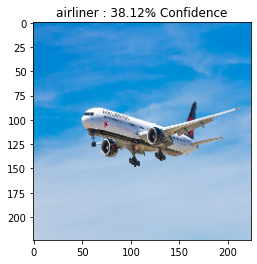

In [48]:
plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [49]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


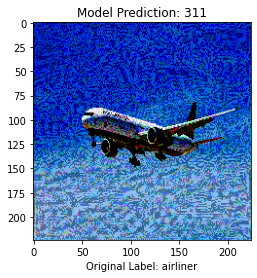

In [71]:
epsilon = 0.16

adv_example_untargeted_label = fast_gradient_method(logits_model, image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = pretrained_model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (224,224,3)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(image_class))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


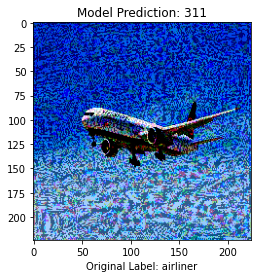

In [78]:
epsilon = 0.22

# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 319

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = fast_gradient_method(logits_model, image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = pretrained_model.predict(adv_example_targeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (224,224,3)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(image_class))

plt.show()